In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [10]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [11]:
#path = "D:/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [12]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'alpha':[0.0001, 0.001, 0.01],
    'l1_ratio':[0.15,0.30],
    'epsilon':[0.1,0.3,0.5],
    'validation_fraction':[0.1,0.2],
    'n_iter_no_change':[5,10]
 }

In [15]:
sgd_clf = GridSearchCV(SGDClassifier(loss='log',fit_intercept=True,n_iter=n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1, verbose=4, iid=True, cv=5)

In [16]:
model = sgd_clf.fit(X_train_cls, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 82.4min finished
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [17]:
model.best_score_

0.6989333333333333

In [18]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'l1_ratio': 0.15, 'epsilon': 0.5, 'n_iter_no_change': 10, 'alpha': 0.001, 'validation_fraction': 0.2}
alpha: 0.001
epsilon: 0.5
l1_ratio: 0.15
n_iter_no_change: 10
validation_fraction: 0.2


In [19]:
pickle.dump(model,open("SGDClassifier_cls_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [20]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [21]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = SGDClassifier(loss='log',alpha=model.best_params_['alpha'],l1_ratio=model.best_params_['l1_ratio'], 
                              epsilon=model.best_params_['epsilon'],validation_fraction = model.best_params_['validation_fraction'],
                              n_iter_no_change=model.best_params_['n_iter_no_change'],
                                   fit_intercept=True, n_iter=n_iter, n_jobs=-1)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_cls[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_cls)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_cls)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_cls)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.28 sec
Validation Accuracy: 50.33%
Validation Time:0.08 sec
Test Accuracy: 50.11%
Test Time:0.02 sec
(0.46864444444444614, 0.22, 0.6226666666666667)
MRR: 0.46864444444444614
MRR Time:0.98 sec
SampleSize: 500


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:0.89 sec
Validation Accuracy: 52.58%
Validation Time:0.03 sec
Test Accuracy: 52.71%
Test Time:0.07 sec
(0.46314444444444536, 0.22133333333333333, 0.5833333333333334)
MRR: 0.46314444444444536
MRR Time:0.69 sec
SampleSize: 1000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:1.79 sec
Validation Accuracy: 54.65%
Validation Time:0.02 sec
Test Accuracy: 55.71%
Test Time:0.01 sec
(0.49328888888889066, 0.25066666666666665, 0.6426666666666667)
MRR: 0.49328888888889066
MRR Time:0.50 sec
SampleSize: 10000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:19.06 sec
Validation Accuracy: 60.81%
Validation Time:0.03 sec
Test Accuracy: 60.25%
Test Time:0.03 sec
(0.5444777777777798, 0.30533333333333335, 0.7213333333333334)
MRR: 0.5444777777777798
MRR Time:0.49 sec
SampleSize: 20000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:38.91 sec
Validation Accuracy: 62.42%
Validation Time:0.04 sec
Test Accuracy: 62.43%
Test Time:0.01 sec
(0.5816111111111134, 0.35333333333333333, 0.7573333333333333)
MRR: 0.5816111111111134
MRR Time:0.54 sec
SampleSize: 50000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:98.35 sec
Validation Accuracy: 63.03%
Validation Time:0.04 sec
Test Accuracy: 61.85%
Test Time:0.03 sec
(0.5958333333333351, 0.37466666666666665, 0.7726666666666666)
MRR: 0.5958333333333351
MRR Time:0.55 sec
SampleSize: 75000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Train Time:152.69 sec
Validation Accuracy: 64.69%
Validation Time:0.05 sec
Test Accuracy: 64.27%
Test Time:0.07 sec
(0.6009222222222241, 0.37666666666666665, 0.7733333333333333)
MRR: 0.6009222222222241
MRR Time:0.62 sec
[0.5033, 0.5258, 0.5465, 0.6081, 0.6242, 0.6303, 0.6469]
[0.5011, 0.5271, 0.5571, 0.6025, 0.6243, 0.6185, 0.6427]
[0.46864444444444614, 0.46314444444444536, 0.49328888888889066, 0.5444777777777798, 0.5816111111111134, 0.5958333333333351, 0.6009222222222241]
[0.22, 0.22133333333333333, 0.25066666666666665, 0.30533333333333335, 0.35333333333333333, 0.37466666666666665, 0.37666666666666665]
[0.6226666666666667, 0.5833333333333334, 0.6426666666666667, 0.7213333333333334, 0.7573333333333333, 0.7726666666666666, 0.7733333333333333]


In [24]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Accuracy_cls.png")
    #plt.show()

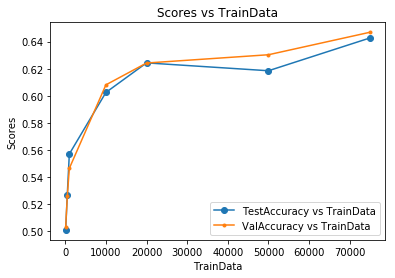

In [25]:
accuracyVisualization()

In [26]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGDClassifier_Mrr_cls.png")
    plt.show()

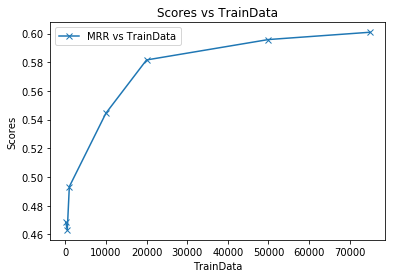

In [27]:
mrrVisualization()

In [28]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SGD_Precision_cls.png")
    plt.show()

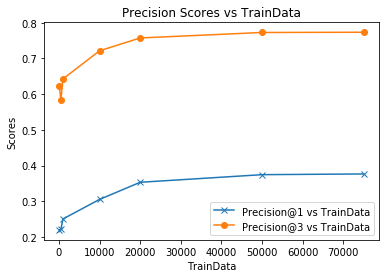

In [29]:
precisionVisualization()